In [1]:
import numpy as np
import nibabel as nib
from nibabel import processing

import matplotlib.pyplot as plt
import albumentations as A

import os

import skimage.transform

In [4]:
model = os.path.abspath('./t1_strip.keras')
t1_path = '/hpf/projects/ndlamini/scratch/wgao/skull_strip_t1/test/121/121_T1.nii.gz'

save_prediction_path = '/hpf/projects/ndlamini/scratch/wgao/skull_strip_t1/test/121/121_T1_mask.nii.gz'

In [5]:
%%bash -s {model} {t1_path}
srun --mem=4G --gpus=1 python3 predict.py $1 $2

2023-08-24 15:49:36.337086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 15:49:42.753848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 15:49:42.781149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-24 15:49:42.785260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

1/1 [==============================] - 6s 6s/step
Prediction saved to pred.npy


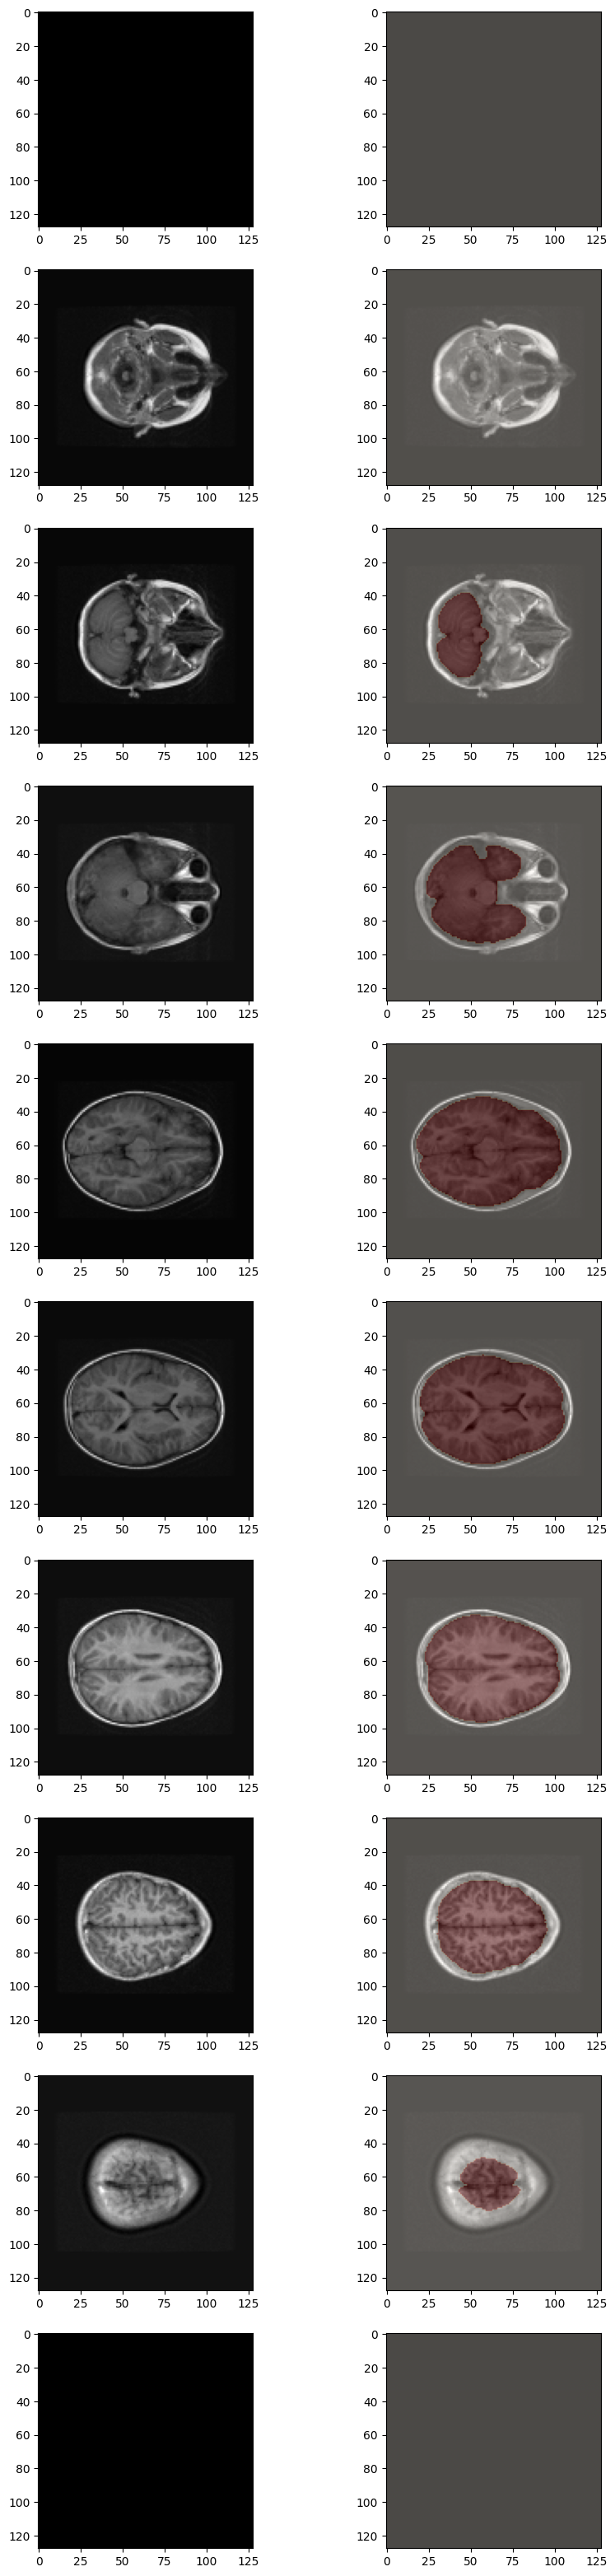

In [6]:
NUM_SLICES_TO_DISPLAY = 10

t1 = nib.load(t1_path)

t1_resampled = processing.conform(t1)

p = np.round(np.load('./pred.npy'))

# display the slices where the predicted mask is non-zero
non_zero_slices = np.sort(np.unique(np.nonzero(p[0 , :, :, :, 1])))
choices = np.round(np.linspace(non_zero_slices[0], non_zero_slices[-1], num=NUM_SLICES_TO_DISPLAY)).astype(int)

# init plots
f, ax = plt.subplots(len(choices), 2, figsize = (10, 4 * len(choices)))

for idx, slice in enumerate(choices):
    ax[idx][0].imshow(A.resize(t1_resampled.get_fdata()[:, :, slice * 2], 128, 128), cmap='gray')
    ax[idx][1].imshow(A.resize(t1_resampled.get_fdata()[:, :, slice * 2], 128, 128), cmap='gray')
    ax[idx][1].imshow(p[0 , :, :, slice, 1], cmap='OrRd', alpha=0.3)
plt.show()

In [ ]:
# resize back up to 256 x 256 x256
result = skimage.transform.resize(p[0 , :, :, :, 1], (256, 256, 256), order=0)
result_img = nib.Nifti1Image(result, t1_resampled.affine)

result_img = processing.conform(result_img, t1.shape, t1.header.get_zooms(), order=0)

nib.save(result_img, save_prediction_path)